# Сегментации легкие человека на радиографическом снимке

### Импорт необходимых библиотек и загрузка датасета

In [ ]:
import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling     # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate             # cлои библиотеки Keras
from keras.layers import Rescaling, Resizing                                          # cлои библиотеки Keras
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam                                                     # оптимизатор Adam
from keras.preprocessing.image import  load_img                                       # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса

from keras.callbacks import EarlyStopping

import random                                                                         # генератор случайных чисел

import numpy as np                                                                    # библиотека линейной алгебры
import pandas as pd                                                                   # библиотека обработки табличных данных
import os                                                                             # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)

import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

100%|██████████| 778M/778M [00:09<00:00, 81.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tawsifurrahman/covid19-radiography-database/versions/5


In [ ]:
dataset_path = path + '/COVID-19_Radiography_Dataset/Normal'

image_dir = 'images'
label_dir = 'masks'

### Визуализация данных

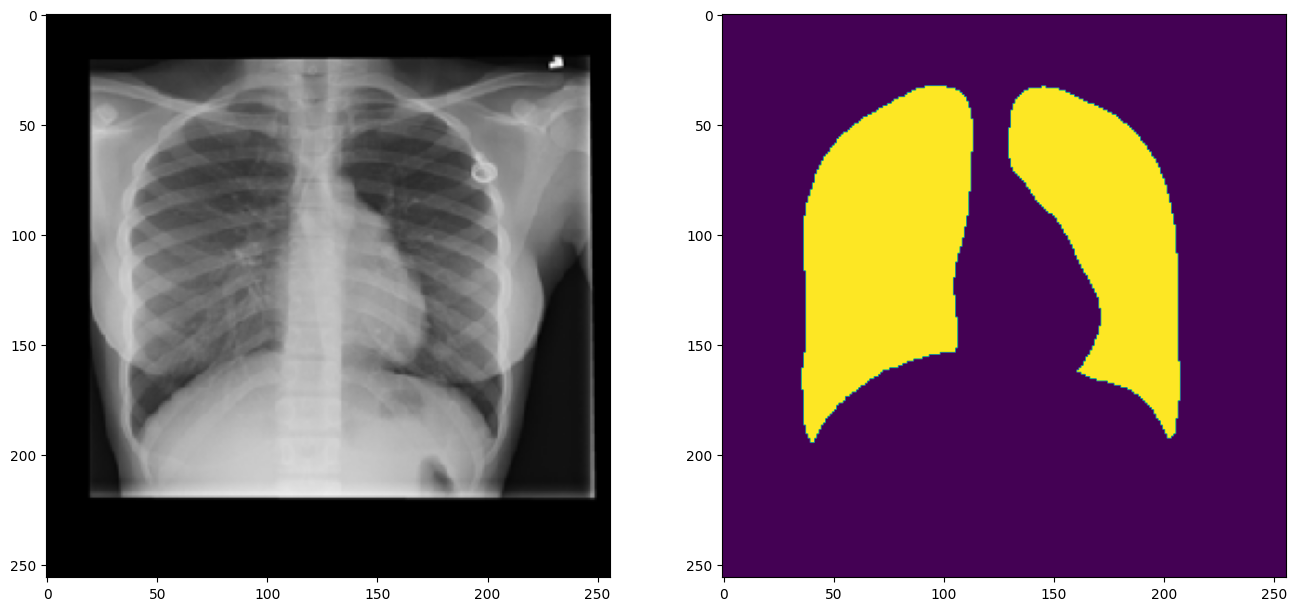

In [ ]:
original_image = os.path.join(dataset_path, image_dir, 'Normal-1.png')                           # путь до ориганального изображения
label_image_semantic = os.path.join(dataset_path, label_dir, 'Normal-1.png')                     # путь до маски

fig, axs = plt.subplots(1, 2, figsize=(16, 8))                                                   # задаем область для построения (канвас)

img = np.array(load_img(original_image, target_size=(256, 256), color_mode='rgb'))               # загружаем оригинальное изображение как RGB с 3 каналами
mask = np.array(load_img(label_image_semantic, target_size=(256, 256), color_mode='grayscale'))  # загружаем маску как "отеннки серого", т.е. в один канал

axs[0].imshow(img)  # отрисовываем оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask) # отрисовываем маску (одноканальное изображение, каждый класс отображается как отдельный цвет)
axs[1].grid(False)

### Создание датасета для обучения

Массив (список) из ссылок на файлы с изображениями `input_img_path` и масками `target_img_path`

In [ ]:
input_img_path = sorted(
    [
        os.path.join(dataset_path, image_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, image_dir))
        if fname.endswith(".png")
    ]
)

target_img_path = sorted(
    [
        os.path.join(dataset_path, label_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, label_dir))
        if fname.endswith(".png")
    ]
)

In [ ]:
batch_size = 16
img_size = (256, 256)
NUM_CLASSES = 2

In [ ]:
# Генератор для перебора данных (в виде массивов Numpy)
class datasetGenerator(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_path, target_img_path = None, num_classes = NUM_CLASSES, validation = False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.num_classes = num_classes
        self.validation = validation


    def __len__(self):
        """Возвращает число мини-батчей обучающей выборки"""
        return len(self.target_img_path) // self.batch_size


    def __getitem__(self, idx):
        """Возвращает кортеж (input, target) соответствующий индексу пакета idx"""

        # Формируем пакеты из ссылок путем среза длинной в batch_size и возвращаем пакет по индексу
        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        # Создадим массив numpy, заполненный нулями, для входных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 3) и типа данных float32
        x = np.zeros((self.batch_size, *self.img_size, 3), dtype="float32")

        # Создадим массив numpy, заполненный нулями, для выходных данных формы (BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, 1) и типа данных uint8
        y = np.zeros((self.batch_size, *self.img_size, self.num_classes), dtype="uint8")

        # В цикле заполняем массивы с изображениями x и y
        # Перебираем пакеты из путей batch_input_img_path и batch_target_img_path к изображениям
        # zip возвращает для нескольких последовательностей список кортежей из элементов последовательностей с одинаковыми индексами
        for _, paths in enumerate(zip(batch_input_img_path, batch_target_img_path)):

            # Загружаем изображение и маску используя путь файловой системы
            img = np.array(load_img(paths[0], target_size=self.img_size, color_mode='rgb'))         # 3 канала для изображения
            mask = np.array(load_img(paths[1], target_size=self.img_size, color_mode='grayscale'))  # 1 канал для маски

            if self.validation:
                # Применяем аугментацию для проверочной выборки (p - вероятность применения, 0.5 - для каждого второго изображения)
                transform = A.Compose([                                      # определяем функцию аугментации
                                A.Flip(p=0.5),                               # Отражение изображения по горизонтали и вертикали
                                A.RandomRotate90(always_apply=False, p=0.5), # Случайный поворот на 90 градусов
                ])
                transformed = transform(image=img, mask=mask)               # применяем функцию аугментации в изображению и маске
                img = transformed["image"]
                mask = transformed["mask"]

            x[_] = img / 255                                                # нормализуем изображение
            y[_] = to_categorical(mask / 255, num_classes=self.num_classes) # преобразует маску из целых чисел в двоичную матрицу класса

        return x, y

In [ ]:
import random

seed = 1523
random.Random(seed).shuffle(input_img_path)
random.Random(seed).shuffle(target_img_path)

In [ ]:
percent = 20 # процент расщепления validation

val_samples = len(input_img_path) * percent // 100

# Расщепим наш датасет  на обучающую и проверочные выборки
train_input_img_path = input_img_path[:-val_samples]
train_target_img_path = target_img_path[:-val_samples]
val_input_img_path = input_img_path[-val_samples:]
val_target_img_path = target_img_path[-val_samples:]

print(len(train_input_img_path))
print(len(val_input_img_path))

8154
2038


In [ ]:
train_gen = datasetGenerator(batch_size, img_size, train_input_img_path, train_target_img_path, NUM_CLASSES)
val_gen = datasetGenerator(batch_size, img_size, val_input_img_path, val_target_img_path, NUM_CLASSES, validation = True)

### Архитектура сети UNET++

In [ ]:
def unet_plus_plus(input_size, num_classes, base_filter_num=64):
    inputs = Input(input_size)
    conv0_0 = Conv2D(base_filter_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv0_0 = Conv2D(base_filter_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_0)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv0_0)

    conv1_0 = Conv2D(base_filter_num * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv1_0 = Conv2D(base_filter_num * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_0)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv1_0)

    up1_0 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_0)
    merge00_10 = Concatenate()([conv0_0,up1_0])
    conv0_1 = Conv2D(base_filter_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge00_10)
    conv0_1 = Conv2D(base_filter_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_1)

    conv2_0 = Conv2D(base_filter_num * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv2_0 = Conv2D(base_filter_num * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_0)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv2_0)

    up2_0 = Conv2DTranspose(base_filter_num*  2, (2, 2), strides=(2, 2), padding='same')(conv2_0)
    merge10_20 = Concatenate()([conv1_0,up2_0])
    conv1_1 = Conv2D(base_filter_num * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge10_20)
    conv1_1 = Conv2D(base_filter_num * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_1)

    up1_1 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_1)
    merge01_11 = Concatenate()([conv0_0,conv0_1,up1_1])
    conv0_2 = Conv2D(base_filter_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge01_11)
    conv0_2 = Conv2D(base_filter_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_2)

    conv3_0 = Conv2D(base_filter_num * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv3_0 = Conv2D(base_filter_num * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_0)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3_0)

    up3_0 = Conv2DTranspose(base_filter_num * 4, (2, 2), strides=(2, 2), padding='same')(conv3_0)
    merge20_30 = Concatenate()([conv2_0,up3_0])
    conv2_1 = Conv2D(base_filter_num * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge20_30)
    conv2_1 = Conv2D(base_filter_num * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_1)

    up2_1 = Conv2DTranspose(base_filter_num * 2, (2, 2), strides=(2, 2), padding='same')(conv2_1)
    merge11_21 = Concatenate()([conv1_0,conv1_1,up2_1])
    conv1_2 = Conv2D(base_filter_num * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge11_21)
    conv1_2 = Conv2D(base_filter_num * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_2)

    up1_2 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_2)
    merge02_12 = Concatenate()([conv0_0,conv0_1,conv0_2,up1_2])
    conv0_3 = Conv2D(base_filter_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge02_12)
    conv0_3 = Conv2D(base_filter_num, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv0_3)

    conv4_0 = Conv2D(base_filter_num * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv4_0 = Conv2D(base_filter_num * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_0)

    up4_0 = Conv2DTranspose(base_filter_num * 8, (2, 2), strides=(2, 2), padding='same')(conv4_0)
    merge30_40 = Concatenate()([conv3_0,up4_0])
    conv3_1 = Conv2D(base_filter_num * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge30_40)
    conv3_1 = Conv2D(base_filter_num * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_1)

    up3_1 = Conv2DTranspose(base_filter_num * 4, (2, 2), strides=(2, 2), padding='same')(conv3_1)
    merge21_31 = Concatenate()([conv2_0,conv2_1,up3_1])
    conv2_2 = Conv2D(base_filter_num * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge21_31)
    conv2_2 = Conv2D(base_filter_num * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_2)

    up2_2 = Conv2DTranspose(base_filter_num * 2, (2, 2), strides=(2, 2), padding='same')(conv2_2)
    merge12_22 = Concatenate()([conv1_0,conv1_1,conv1_2,up2_2])
    conv1_3 = Conv2D(base_filter_num * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge12_22)
    conv1_3 = Conv2D(base_filter_num * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_3)

    up1_3 = Conv2DTranspose(base_filter_num, (2, 2), strides=(2, 2), padding='same')(conv1_3)
    merge03_13 = Concatenate()([conv0_0,conv0_1,conv0_2,conv0_3,up1_3])
    conv0_4 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge03_13)
    conv0_4 = Conv2D(base_filter_num, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv0_4)

    outputs = Conv2D(num_classes, kernel_size = (1, 1), activation = 'softmax')(conv0_4)

    model = Model(inputs, outputs)

    return model

In [ ]:
num_classes = NUM_CLASSES                           # 2 класса объектов
input_shape = (img_size[0], img_size[1], 3)         # размер к которому преобразуем изображение, 3 канала - RGB
model = unet_plus_plus(input_shape, num_classes)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_6        │ (None, 32, 32, 512)    │      2,097,664 │ conv2d_21[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 64, 64, 256)    │        524,544 │ conv2d_13[0][0]        │
│ (Conv2DTranspose)    

 Total params: 36,158,018 (137.93 MB)

 Trainable params: 36,158,018 (137.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

### Обучение модели

In [ ]:
epochs = 5

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks
)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


509/509 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8679 - loss: 0.2997

<ipython-input-7-499b016ab073>:43: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),                               # Отражение изображения по горизонтали и вертикали


509/509 ━━━━━━━━━━━━━━━━━━━━ 1331s 2s/step - accuracy: 0.8681 - loss: 0.2994 - val_accuracy: 0.9424 - val_loss: 0.2171
Epoch 2/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 1140s 2s/step - accuracy: 0.9909 - loss: 0.0239 - val_accuracy: 0.9365 - val_loss: 0.2207
Epoch 3/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 1107s 2s/step - accuracy: 0.9912 - loss: 0.0233 - val_accuracy: 0.9406 - val_loss: 0.1990
Epoch 4/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 1164s 2s/step - accuracy: 0.9940 - loss: 0.0153 - val_accuracy: 0.9362 - val_loss: 0.2002
Epoch 5/5
509/509 ━━━━━━━━━━━━━━━━━━━━ 1111s 2s/step - accuracy: 0.9952 - loss: 0.0117 - val_accuracy: 0.9097 - val_loss: 0.5615


### Визуальная оценка результата сегментации на тестовой выборке

Сравним оригинальную маску и предсказанную маску на тестовой выборке.

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Входное изображение', 'Оригинальная маска', 'Предсказанная маска']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(display_list[0])            # отображаем картинку
    plt.imshow(display_list[i],alpha=0.8)  # отображаем маску с прозрачностью 50%
    plt.axis('off')
  plt.show()

Определим функцию создания маски и отобразим 10 образцов изображений, а также соответствующих им оригинальные и предсказанные маски.

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


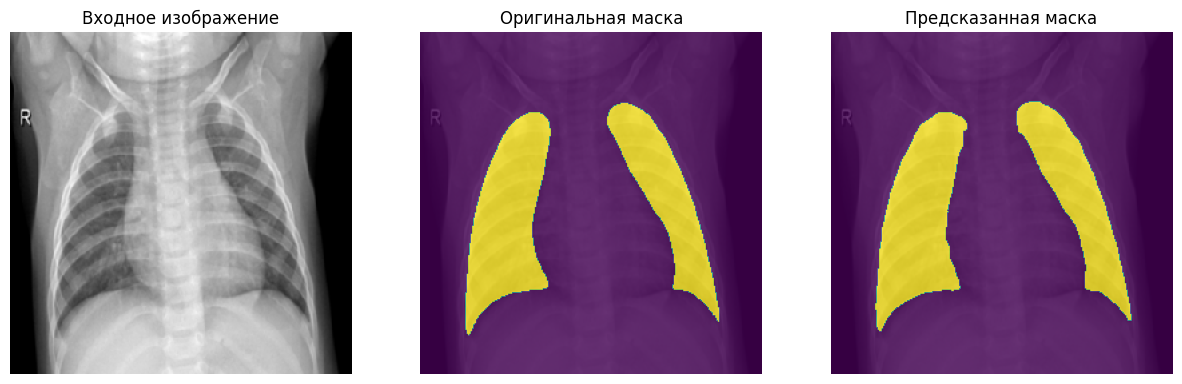

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


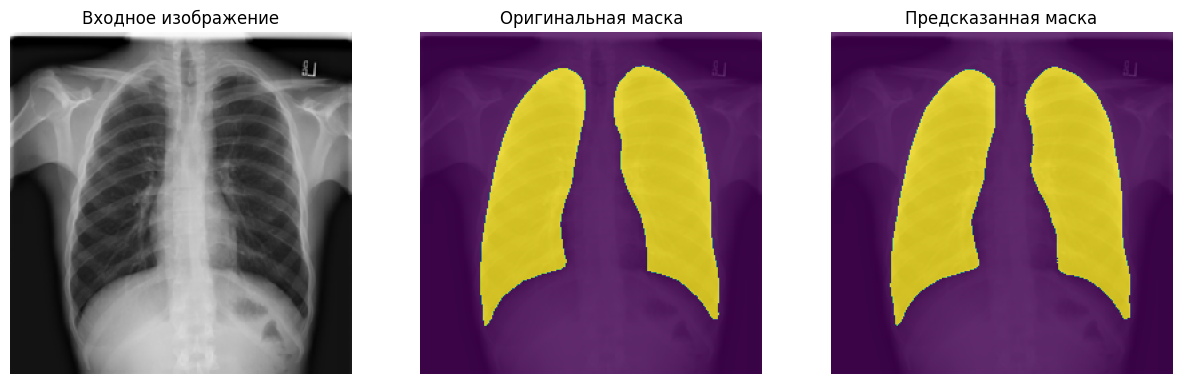

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


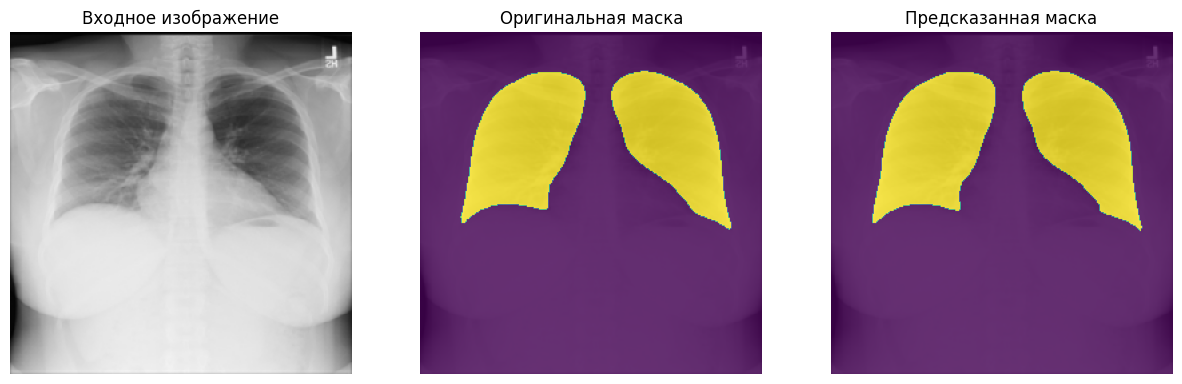

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


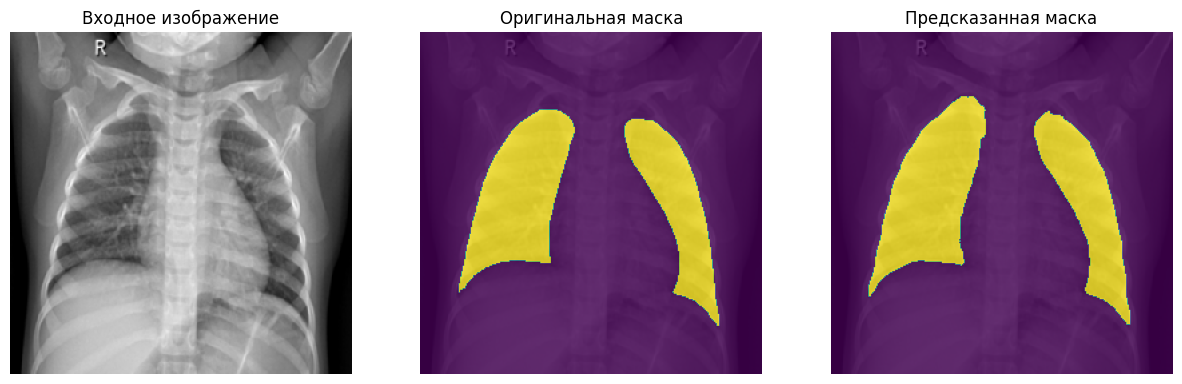

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


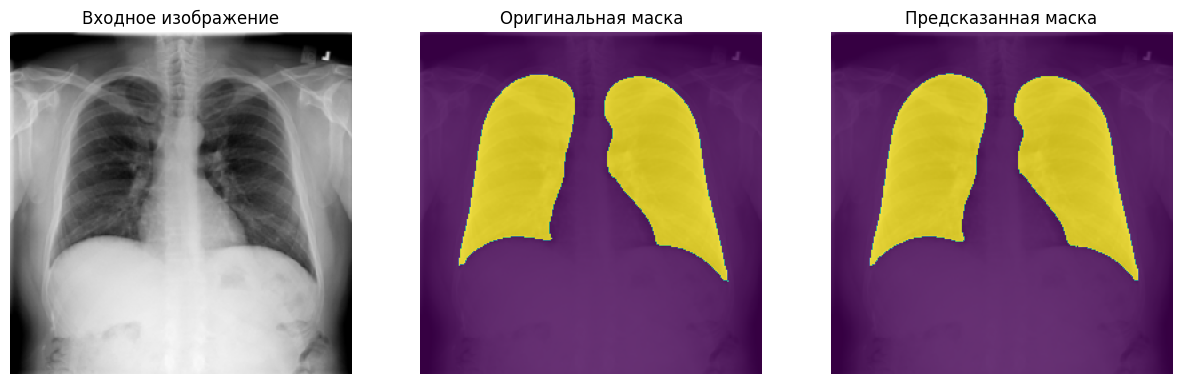

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


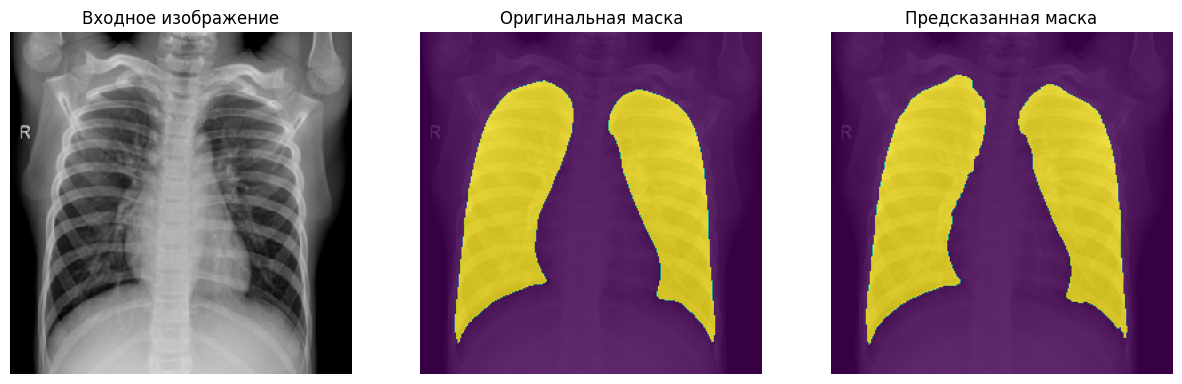

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


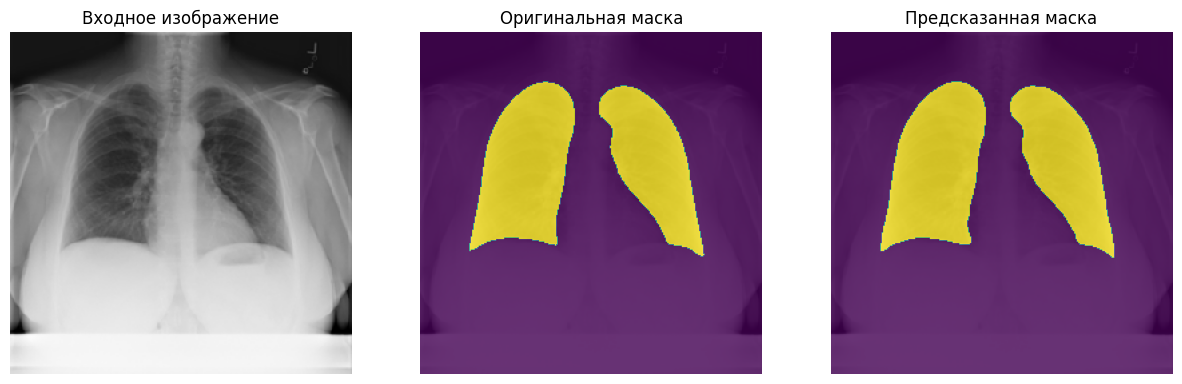

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


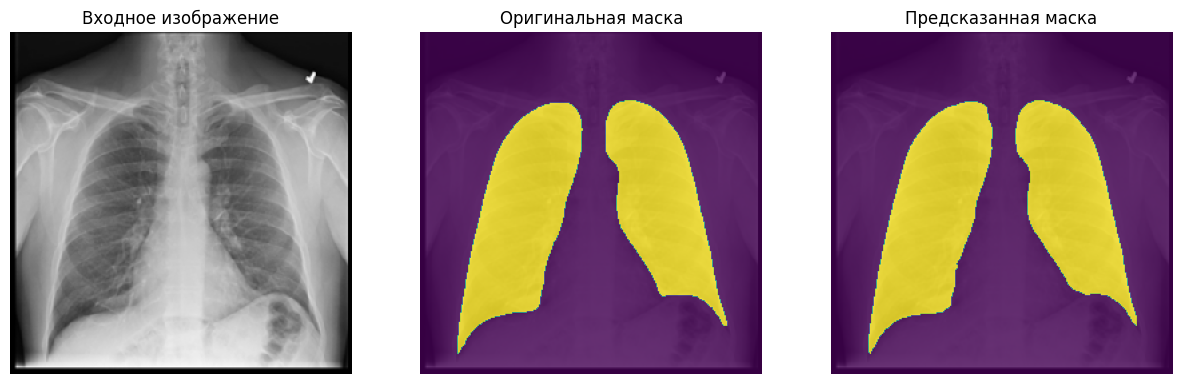

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


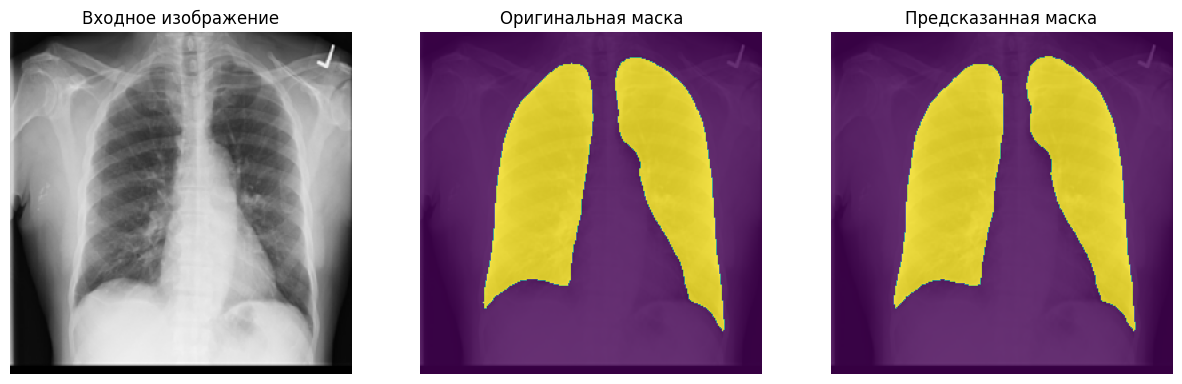

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


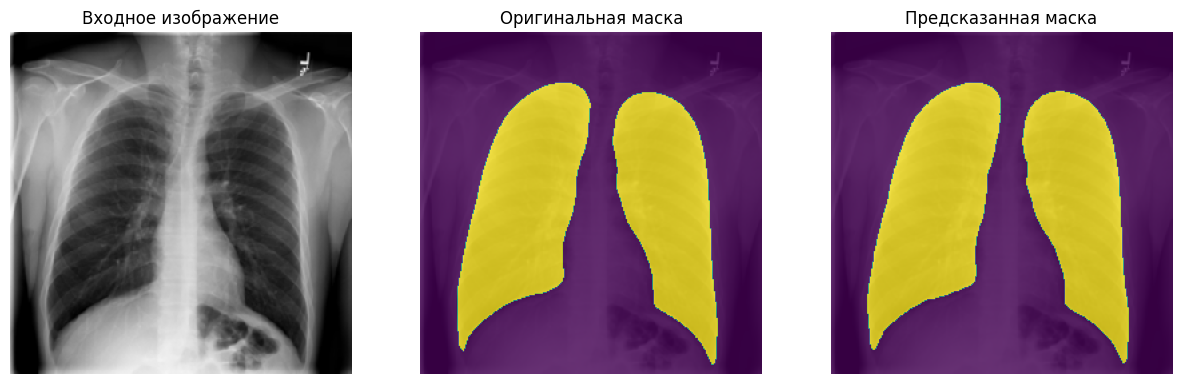

In [ ]:
for index in range(10): # выбираем 10 картинок и выводим их в цикле
    img = np.array(load_img(val_input_img_path[index], target_size=(256, 256), color_mode='rgb')) # загружаем картинку для предсказания
    mask = np.array(load_img(val_target_img_path[index], target_size=(256, 256), color_mode='grayscale')) # загружаем маску для сравнения с предсказанием

    # Запускаем модель в режиме предсказания
    test = model.predict(np.expand_dims(img, 0) / 255)

    # Выбираем наиболее веротный класс
    test = np.argmax(test, axis=-1)

    display([img.reshape(1, 256, 256, 3)[0], mask, test[0]])  # передаем в функцию display изображение, оригинальную маску и предсказанную